In [3]:
import jax

jax.config.update("jax_enable_x64", True)
import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time

from jorbit import Ephemeris, Particle
from jorbit.astrometry.sky_projection import on_sky
from jorbit.mpchecker.parse_jorbit_ephem import load_mpcorb
from jorbit.utils.horizons import get_observer_positions
from jorbit.utils.kepler import kepler
from jorbit.utils.mpc import unpack_epoch
from jorbit.utils.states import CartesianState, heliocentric_to_barycentric

In [7]:
# set up to the two ephemerides that we'll call when shifting initial states from one to the other

eph_430 = Ephemeris(
    ssos="default solar system",
    earliest_time=Time("1860-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="430",
)

eph_440 = Ephemeris(
    ssos="default solar system",
    earliest_time=Time("1860-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="440",
)

In [8]:
# load the cached MPCORB.dat table of orbits just to get some reasonable elements
orbs = load_mpcorb()

In [9]:
# set up things that will stay constant for every tested orbit

times = Time(
    jnp.linspace(
        Time("2000-01-01").tdb.jd, Time("2050-01-01").tdb.jd, int(365 * 50 / 10)
    ),
    format="jd",
    scale="tdb",
)

# dummy particles for ephemeris comparison- will overwrite their states repeatedly,
# but this way we don't have to re-compile/re-initialize everything each time
p440 = Particle.from_horizons(
    name="274301", time=Time("2025-01-01"), de_ephemeris_version="440"
)
p430 = Particle(
    state=p440.cartesian_state, name="274301_430", de_ephemeris_version="430"
)

In [10]:
# get the sky coordinates of the sun so that we can filter out daytime observations

sun_x = eph_440.state(times)["sun"]["x"].value
sun_v = eph_440.state(times)["sun"]["v"].value
acc_func = jax.tree_util.Partial(lambda x: jnp.ones_like(x.tracer_positions) * 1e-16) # for some reason we nan with zero acceleration?
observer_pos = get_observer_positions(times, observatories="kitt peak", de_ephemeris_version="440")

# way faster to just loop than to vmap
sun_coords = []
for i in range(len(times)):
    sc = on_sky(
        jnp.array(sun_x[i]),
        jnp.array(sun_v[i]),
        jnp.array(times.tdb.jd[i]),
        jnp.array(observer_pos[i]),
        acc_func
    )
    sun_coords.append(sc)
sun_coords = jnp.array(sun_coords)
sun_coords = SkyCoord(ra=sun_coords[:,0]*u.rad, dec=sun_coords[:,1]*u.rad)

In [11]:
tmp = orbs[1900]
epoch = unpack_epoch(tmp["Epoch"][0])

helio_430 = {
    "a_helio": tmp["a"][0],
    "ecc_helio": tmp["e"][0],
    "inc_helio": tmp["Incl."][0],
    "Omega_helio": tmp["Node"][0],
    "omega_helio": tmp["Peri"][0],
    "nu_helio": kepler(M=tmp["M"][0] * jnp.pi / 180, ecc=tmp["e"][0]) * 180 / jnp.pi,
}

bary_430 = heliocentric_to_barycentric(
    heliocentric_dict=helio_430,
    time=epoch,
    de_ephemeris_version="430",
).to_cartesian()

sun_430 = eph_430.state(epoch)["sun"]
sun_440 = eph_440.state(epoch)["sun"]

delta_x = sun_440["x"] - sun_430["x"]
delta_v = sun_440["v"] - sun_430["v"]

bary_440 = CartesianState(
    x=bary_430.x + delta_x.value,
    v=bary_430.v + delta_v.value,
    acceleration_func_kwargs=bary_430.acceleration_func_kwargs,
    time=epoch.tdb.jd,
)

In [12]:
p430_pos = p430.ephemeris(times, observer="kitt peak", state=bary_430)
p440_pos = p440.ephemeris(times, observer="kitt peak", state=bary_440)

# diff = jax.vmap(sky_sep)(
#     jnp.array(p430_pos.ra.rad),
#     jnp.array(p430_pos.dec.rad),
#     jnp.array(p440_pos.ra.rad),
#     jnp.array(p440_pos.dec.rad),
# )
diff = p430_pos.separation(p440_pos)

mask = p440_pos.separation(sun_coords) < 30*u.deg
diff[mask] = jnp.nan

[Text(0.5, 0, 'time since reference epoch [years]'),
 Text(0, 0.5, 'diff. between DE430 and DE440 integrations [arcsec]')]

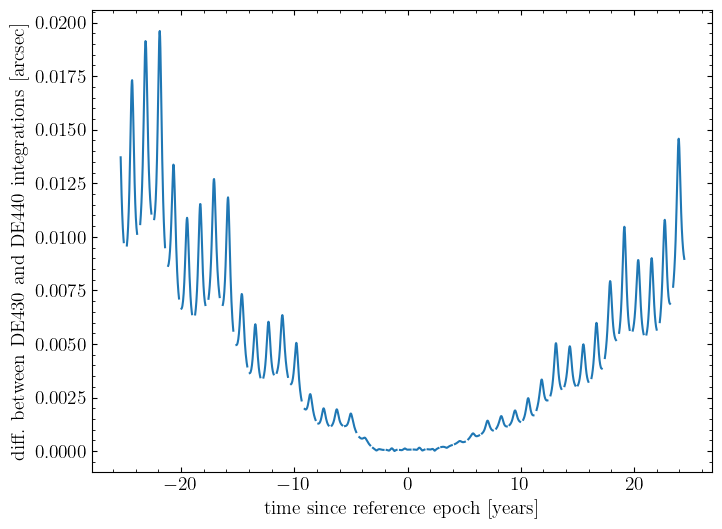

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot((times - epoch).to(u.year), diff.arcsec)
ax.set(
    xlabel="time since reference epoch [years]",
    ylabel="diff. between DE430 and DE440 integrations [arcsec]",
)

In [14]:
from glob import glob

import numpy as np

res_files = glob("/Users/cassese/Downloads/results/*")
res_files = sorted(res_files)

names = []
results = []
for rf in res_files:
    names.append(int(rf.split("/")[-1].split(".")[0]))
    results.append(np.load(rf))

[Text(0.5, 0, 'time since reference epoch [years]'),
 Text(0, 0.5, 'diff. between DE430 and DE440 integrations [arcsec]'),
 (-0.01, 0.1)]

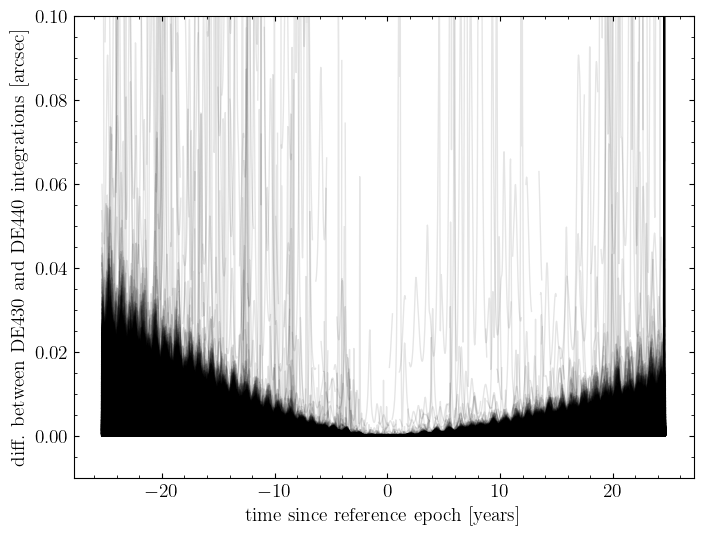

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
for n, res in zip(names, results):
    ax.plot((times - epoch).to(u.year), res, label=str(n), color="k", alpha=0.1, lw=1)
ax.set(
    xlabel="time since reference epoch [years]",
    ylabel="diff. between DE430 and DE440 integrations [arcsec]",
    ylim=(-0.01, 0.1)
)